# STOR 320: Introduction to Data Science
## Spring 2025
## EDA Group 13

## Creator: Meredith Rupp

### Q1: How does the correlation between the number of traffic accidents and poor weather conditions vary across different boroughs in NYC?

In [1]:
# Source for rain severity 
#https://www.nchm.gov.bt/attachment/ckfinder/userfiles/files/Rainfall%20intensity%20classification.pdf
# Source for wind speed severity 
#https://www.weather.gov/pqr/wind

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import warnings

warnings.filterwarnings("ignore")

# Load csv files as dataframes
mta_ridership = pd.read_csv('MTA_Daily_Ridership.csv')
nyc_accidents = pd.read_csv('NYC Accidents 2020.csv')
weather = pd.read_csv('NYC_weather_data_Jan-Aug2020.csv')

# Filter for only the needed columns and drop any null data
nyc_accidents_clean = nyc_accidents[['CRASH DATE', 'BOROUGH']].dropna(subset=['BOROUGH'])

# Count the number of accidents on a given day for each borough
accident_count = nyc_accidents_clean.groupby(['BOROUGH', 'CRASH DATE']).size().reset_index(name='accident count')

# Create a function to categorize the weather as either 'Poor' or 'Fair'
def classify_weather(day):
    if day['Wind Speed (mph) Max'] >= 24 or day['Precipitation (in) Total'] >= 0.9:
        return 'Poor'
    else:
        return 'Fair'

# The classification of poor weather comes from the Weather and Climate Services for precipitation and The 
# National Weather Services for wind speed

# Apply the function to create the 'condition' column
weather['condition'] = weather.apply(classify_weather, axis=1)

# Merge the weather and cleaned crash data together then filter for necessary columns 
weather_accidents = pd.merge(accident_count, weather, left_on='CRASH DATE', right_on='Date')
weather_accidents = weather_accidents[['BOROUGH', 'CRASH DATE', 'accident count', 'condition']]

weather_accidents.head()

,BOROUGH,CRASH DATE,accident count,condition
0,BRONX,2020-01-01,47,Fair
1,BROOKLYN,2020-01-01,83,Fair
2,MANHATTAN,2020-01-01,24,Fair
3,QUEENS,2020-01-01,76,Fair
4,STATEN ISLAND,2020-01-01,4,Fair


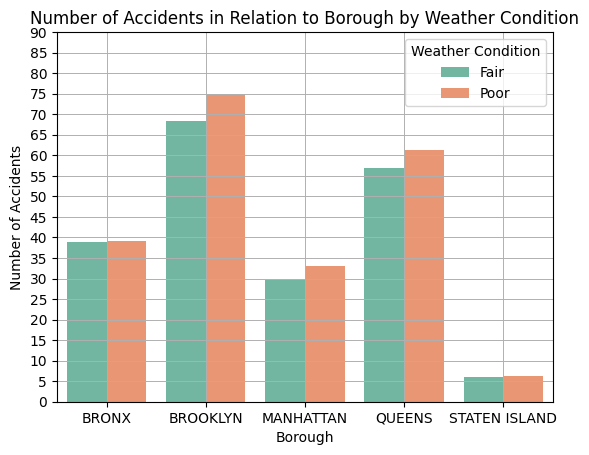

In [2]:
# Create the stacked bar chart to visualize data 
sns.barplot(weather_accidents, x='BOROUGH', y='accident count', hue='condition', palette='Set2', errorbar=None)

# Add labels and supporting features for easier interpretation
plt.title('Number of Accidents in Relation to Borough by Weather Condition')
plt.xlabel('Borough')
plt.ylabel('Number of Accidents')
plt.legend(title='Weather Condition')
plt.grid(True, linestyle='-', linewidth=0.7)
plt.yticks(np.arange(0, 95, 5));

In [3]:
from scipy import stats 

# Further investigate the difference between fair and poor conditions in Brooklyn
brooklyn_poor = weather_accidents[(weather_accidents['BOROUGH'] == 'BROOKLYN') & (
    weather_accidents['condition'] == 'Poor')]['accident count']
brooklyn_fair = weather_accidents[(weather_accidents['BOROUGH'] == 'BROOKLYN') & (
    weather_accidents['condition'] == 'Fair')]['accident count']

# Run statistical tests 
stat, pval = stats.ttest_ind(brooklyn_poor, brooklyn_fair)
print('T-statistic Brooklyn:', stat)
print('P-value Brooklyn:', pval)

# Further investigate the difference between fair and poor conditions in Manhattan 
manhattan_poor = weather_accidents[(weather_accidents['BOROUGH'] == 'MANHATTAN') & (
    weather_accidents['condition'] == 'Poor')]['accident count']
manhattan_fair = weather_accidents[(weather_accidents['BOROUGH'] == 'MANHATTAN') & (
    weather_accidents['condition'] == 'Fair')]['accident count']

# Run statistical tests 
stat, pval = stats.ttest_ind(manhattan_poor, manhattan_fair)
print('T-statistic Manhattan:', stat)
print('P-value Manhattan:', pval)

T-statistic Brooklyn: 1.4322197122132427
P-value Brooklyn: 0.15338206835355866
T-statistic Manhattan: 1.1704906919234093
P-value Manhattan: 0.2429644860587775


### Q2: How does poor weather conditions impact daily subway ridership on the weekends compared to the weekdays?

In [4]:
# Load datasets 
mta_ridership = pd.read_csv('MTA_Daily_Ridership.csv')
nyc_accidents = pd.read_csv('NYC Accidents 2020.csv')
weather = pd.read_csv('NYC_weather_data_Jan-Aug2020.csv')

# Create a function to categorize the weather type 
def classify_weather(day):
    if day['Wind Speed (mph) Max'] >= 24 or day['Precipitation (in) Total'] >= 0.9:
        return 'Poor'
    else:
        return 'Fair'

# The classification of poor weather comes from the Weather and Climate Services for precipitation and The 
# National Weather Services for wind

# Apply the function to create the 'condition' column
weather['condition'] = weather.apply(classify_weather, axis=1)

# Filter the weather and mta ridership datasets for only the necessary columns 
weather_clean = weather[['Date', 'condition']]
mta_clean = mta_ridership[['Date', 'Subways: Total Estimated Ridership']]

# Merge the two datasets together to have the weather data and the mta ridership data
weather_ridership = pd.merge(weather_clean, mta_clean, on='Date', how='inner')
weather_ridership['Date'] = pd.to_datetime(weather_ridership['Date'])

# Add a column that characterizes the day of the week as either 
weather_ridership['Day_Type'] = np.where(weather_ridership['Date'].dt.dayofweek < 5, 'Weekday', 'Weekend')

weather_ridership.head()

,Date,condition,Subways: Total Estimated Ridership,Day_Type
0,2020-03-01,Fair,2212965,Weekend
1,2020-03-02,Fair,5329915,Weekday
2,2020-03-03,Poor,5481103,Weekday
3,2020-03-04,Poor,5498809,Weekday
4,2020-03-05,Poor,5496453,Weekday


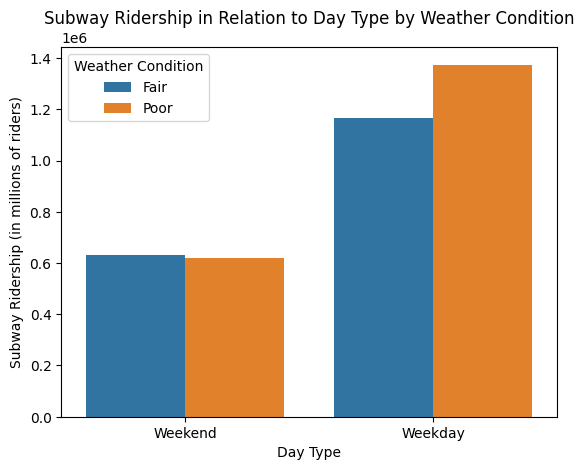

In [5]:
# Create a stacked bar chart to visualize data 
sns.barplot(weather_ridership, x='Day_Type', y='Subways: Total Estimated Ridership', hue='condition', errorbar=None)

# Add labels for easier interpretation 
plt.title('Subway Ridership in Relation to Day Type by Weather Condition')
plt.xlabel('Day Type')
plt.ylabel('Subway Ridership (in millions of riders)')
plt.legend(title='Weather Condition');

## Interpreter: Zain Khan

### Q1: Do serious crashes(where more than 2 people killed or more than 4 injured) have a higher rate of occurrence in poorer conditions or certain times of day?

In [6]:
#Defining variable names
accidents = pd.read_csv("/work/NYC Accidents 2020.csv")
mta = pd.read_csv("/work/MTA_Daily_Ridership.csv")
weather = pd.read_csv("/work/NYC_weather_data_Jan-Aug2020.csv")
burrough_inc = accidents.dropna(subset=['BOROUGH'])

#Helper Functions
# Get the Total num of accidents each hour:
def get_totals(data,column_name,ifTime=False):
    """
    Takes data and a column name and returns an array 
    containing the number of items in each grouping based on column_name.

    data: DataFrame
    column_name: str
    ifTime: bool

    returns: ndarray: array containing the number of items in each grouping based on column_name 
    """
    if ifTime:
        data[column_name] = pd.to_datetime(data[column_name],format='%H:%M:%S')
        data = data.groupby(column_name).size().reset_index()
        data = data.set_index(column_name).rename(columns={0:'Count'})
        data = data.resample('60min').sum()
        data = data.set_index(data.reset_index()[column_name].dt.time)
        totals = data['Count'].values
    else:
        data = data.groupby(column_name).size().reset_index()
        data = data.set_index(column_name).rename(columns={0:'Count'})
        totals = data['Count'].values
    return totals

# Get the proportion of accidents for a specific columns
def get_proportion_df(data,column_name,totals,ifTime=False):
    """
    Takes data and a column name and returns a df containing the groupings,raw counts, 
    and proportions for each grouping in the given column..

    data: DataFrame
    column_name: str
    totals: ndarray
    ifTime: bool

    returns: DataFrame: df containing grouping based on column, counts, and proportions where proportion = count/totals
    """
    if ifTime:
        data[column_name] = pd.to_datetime(data[column_name],format='%H:%M:%S')
        data = data.groupby(column_name).size().reset_index()
        data = data.set_index(column_name).rename(columns={0:'Count'})
        data = data.resample('60min').sum()
        data = data.set_index(data.reset_index()[column_name])
        data['Proportion']= data['Count']/totals
        return data
    else:
        data = data.groupby(column_name).size().reset_index()
        data = data.set_index(column_name).rename(columns={0:'Count'})
        data['Proportion']= data['Count']/totals
    return data
    

total_crashes_every_hour = get_totals(burrough_inc,'CRASH TIME',True)

total_crashes_per_borough = get_totals(burrough_inc,'BOROUGH')

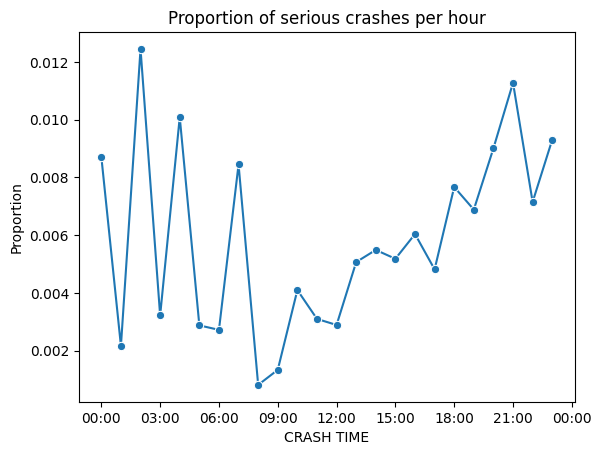

In [7]:
# Get the proportion of serious crashes in each hour and plot

#Define serious crashes to be any where >=4 people were injured or more than 2 people were killed
serious_crashes = burrough_inc[(burrough_inc['NUMBER OF PERSONS INJURED']>=4)|(burrough_inc['NUMBER OF PERSONS KILLED']>=2)]
serious_crashes = serious_crashes[['CRASH TIME']]

#Plot the proportion of crashes for each crash time
resampled = get_proportion_df(serious_crashes,'CRASH TIME',total_crashes_every_hour,True)
sns.lineplot(y='Proportion',x='CRASH TIME',data=resampled,marker='o')
plt.title('Proportion of serious crashes per hour')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))




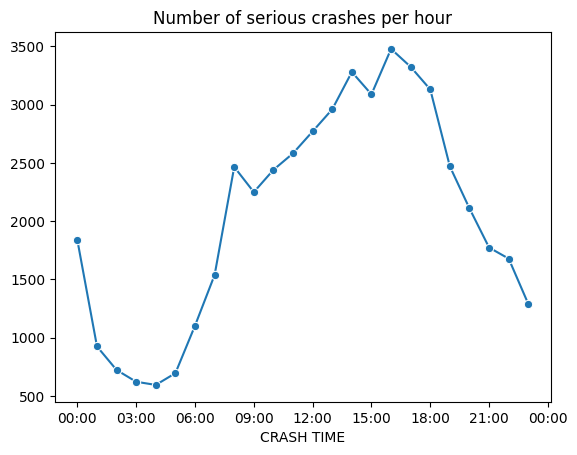

In [8]:
#Plot the raw counts of serious crashes in each hour
sns.lineplot(y=total_crashes_every_hour,x='CRASH TIME',data=resampled,marker='o')
plt.title('Number of serious crashes per hour')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))


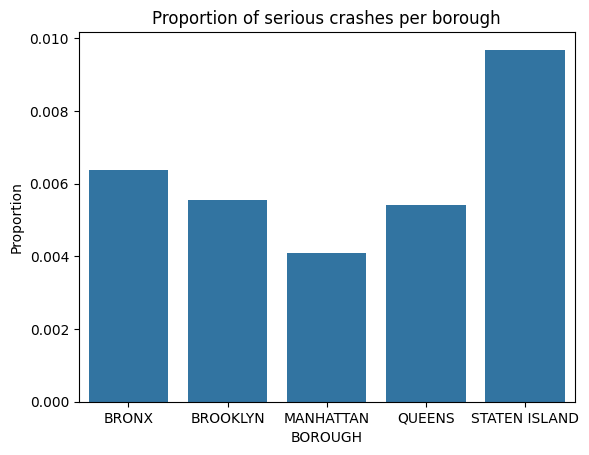

In [9]:
#Plot the proportion of serious crashes in each borough
serious_crashes = burrough_inc[(burrough_inc['NUMBER OF PERSONS INJURED']>=4)|(burrough_inc['NUMBER OF PERSONS KILLED']>=2)]

serious_crashes_burrough = get_proportion_df(serious_crashes,'BOROUGH',total_crashes_per_borough)

sns.barplot(x='BOROUGH',y='Proportion',data=serious_crashes_burrough)
plt.title('Proportion of serious crashes per borough');

### Q2:  Are there more accidents on days with more extreme temperatures(very hot or very cold) and what effect do extreme temperatures have on MTA ridership?


Num of Crashes on days with extreme Temperatures:25354
Num of Crashes on days with non extreme Temperatures:23786


<Figure size 2000x600 with 0 Axes>

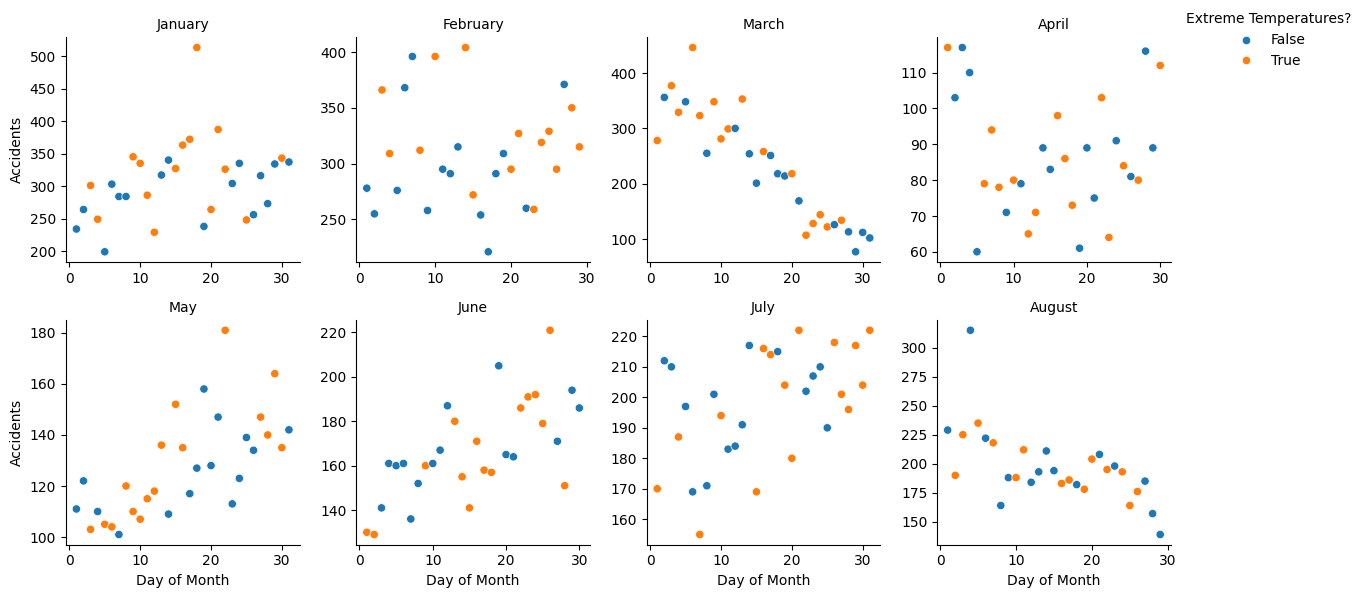

In [10]:
temps = weather[['Date','Temperature (°F) Avg']].copy()

temps.rename(mapper = {"Temperature (°F) Avg": "TemperatureAvg",'Date':"Date"},inplace=True,axis=1)
temps['Date'] = pd.to_datetime(temps['Date'])
temps['Month'] = temps['Date'].dt.to_period('M')
def filter_extremes(group, lower_quantile=0.25, upper_quantile=0.75):
    """
    Filters temperatures in the given group based on the given quantiles.

    group: DataFrame
    lower_quantile: float
    upper_quantile: float

    returns: DataFrame: group with temperatures filtered based on quantiles
    """
    low_thresh = group['TemperatureAvg'].quantile(lower_quantile)
    high_thresh = group['TemperatureAvg'].quantile(upper_quantile)
    return group[(group['TemperatureAvg'] < low_thresh) | (group['TemperatureAvg'] > high_thresh)]


#Filter temperatures on days with extreme temperatures based on whether they are 
#above or below the 25th and 75th quantiles based on the month the temperature was taken.
#This helps to factor in the changing of seasons between the years
extreme_temps = temps.groupby('Month', group_keys=False).apply(filter_extremes)
dates_with_extreme_temperatures = extreme_temps['Date']


burrough_inc['CRASH DATE'] = pd.to_datetime(burrough_inc['CRASH DATE'])
crashes_on_extreme_temps = burrough_inc[burrough_inc['CRASH DATE'].isin(dates_with_extreme_temperatures)]
crashes_on_nonextreme_temps = burrough_inc[~(burrough_inc['CRASH DATE'].isin(dates_with_extreme_temperatures))]

#The raw number of crashes based on what days were classified as extreme.
print(f"Num of Crashes on days with extreme Temperatures:{len(crashes_on_extreme_temps['CRASH DATE'])}")
print(f"Num of Crashes on days with non extreme Temperatures:{len(crashes_on_nonextreme_temps['CRASH DATE'])}")
burrough_inc['isExtreme'] =burrough_inc['CRASH DATE'].isin(dates_with_extreme_temperatures)
counts = burrough_inc.groupby(['CRASH DATE', 'isExtreme']).size().reset_index(name='count')

plt.figure(figsize=(20, 6))
counts['Month'] = counts['CRASH DATE'].dt.strftime('%B')
counts['DateNum'] = counts['CRASH DATE'].dt.day

g= sns.FacetGrid(counts, col="Month", col_wrap=4,sharex=False,sharey=False)
g.map_dataframe(sns.scatterplot, x="DateNum", y="count", hue="isExtreme")

g.set_axis_labels("Day of Month", "Accidents")
g.set_titles(col_template="{col_name}")  # Show month as title
g.add_legend(title="Extreme Temperatures?",loc='upper right');


<Figure size 1500x600 with 0 Axes>

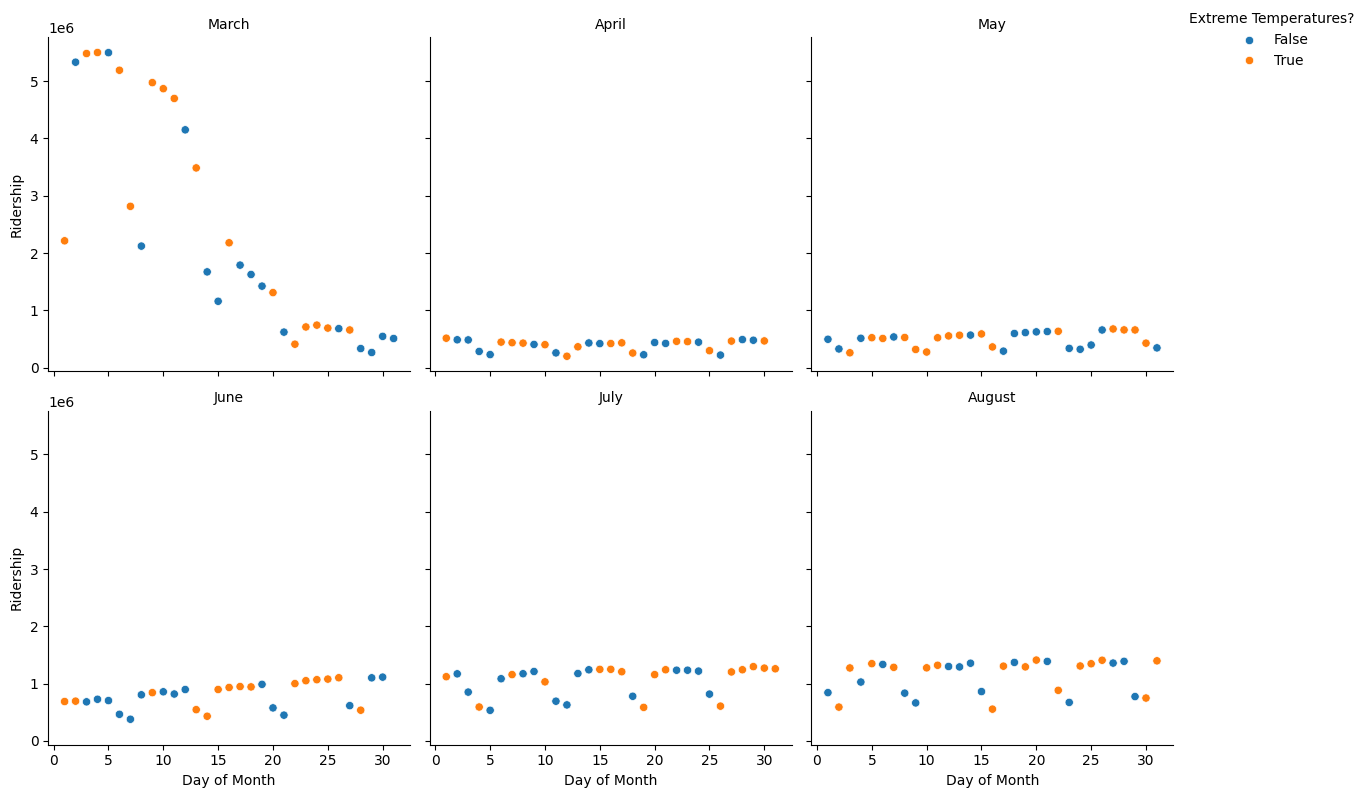

In [11]:
#Do the same as above but for subway ridership
mta['Date'] = pd.to_datetime(mta['Date'])
subway_ridership = mta[['Date','Subways: Total Estimated Ridership']].dropna()
subway_ridership['IsExtreme'] = mta['Date'].isin(dates_with_extreme_temperatures)
subway_ridership
subway_ridership = subway_ridership[(subway_ridership['Date'].dt.month <=8) &(subway_ridership['Date'].dt.year == 2020)]
subway_ridership
plt.figure(figsize=(15, 6))
subway_ridership['Month'] = subway_ridership['Date'].dt.strftime('%B')
subway_ridership['DateNum'] = subway_ridership['Date'].dt.day
subway_ridership.head()


g = sns.FacetGrid(subway_ridership, col='Month', col_wrap=3, sharex=True, sharey=True, height=4)

g.map_dataframe(sns.scatterplot, x='DateNum', y='Subways: Total Estimated Ridership', hue='IsExtreme')

# sns.scatterplot(data=subway_ridership,x='Date',y='Subways: Total Estimated Ridership',hue='IsExtreme')

# plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
# plt.title('MTA ridership on Days with Extreme Temperatures vs. Days with Non-Extreme Temperatures');
g.set_axis_labels("Day of Month", "Ridership")
g.set_titles(col_template="{col_name}")  # Show month as title
g.add_legend(title="Extreme Temperatures?",loc='upper right');

## Interpreter: Christian Dita 
(If you do not have a second interpreter, just remove this section)

### Q1: Which borough has the highest density of traffic accidents and how might it be affected by the time of day (i.e. morning/evening rush or late night) or by poor weather conditions?

BOROUGH
BROOKLYN         16907
QUEENS           14017
BRONX             9417
MANHATTAN         7353
STATEN ISLAND     1446
Name: count, dtype: int64


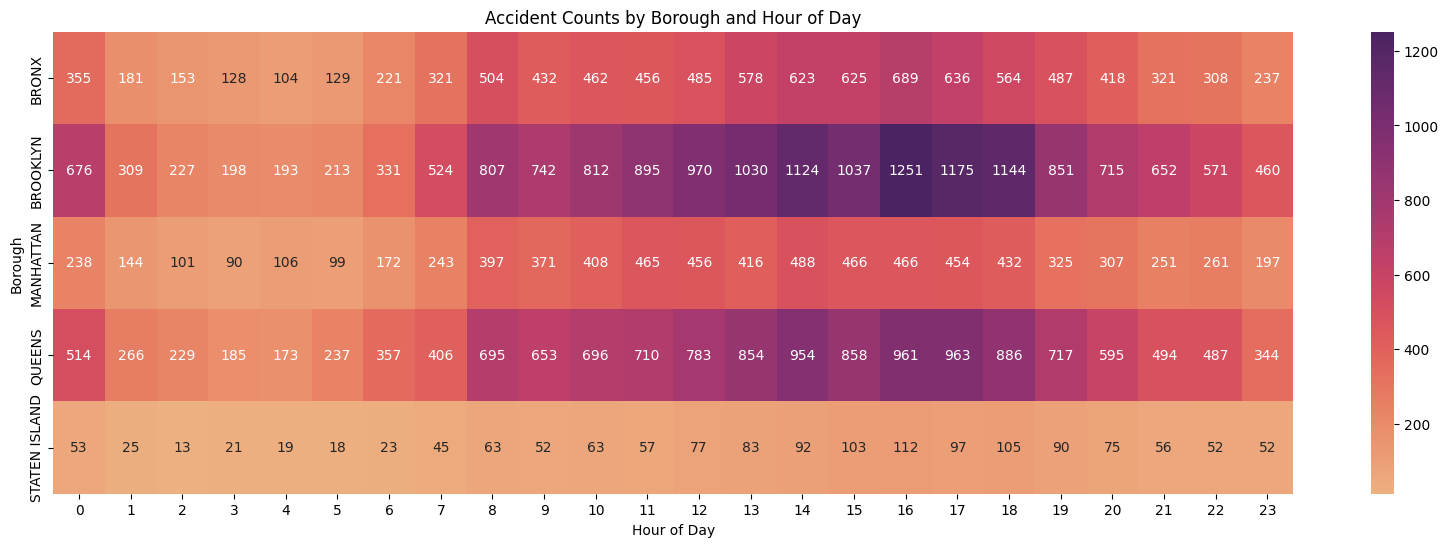

In [12]:
#Data cleaning
accidents["CRASH DATE"] = pd.to_datetime(accidents["CRASH DATE"])
accidents["CRASH TIME"] = pd.to_datetime(accidents["CRASH TIME"])
accidents["BOROUGH"] = accidents["BOROUGH"].astype("category")
accidents["VEHICLE TYPE CODE 1"] = accidents["VEHICLE TYPE CODE 1"].astype("category")
accidents["VEHICLE TYPE CODE 2"] = accidents["VEHICLE TYPE CODE 2"].astype("category")
accidents["VEHICLE TYPE CODE 3"] = accidents["VEHICLE TYPE CODE 3"].astype("category")
accidents["VEHICLE TYPE CODE 4"] = accidents["VEHICLE TYPE CODE 4"].astype("category")
accidents["VEHICLE TYPE CODE 5"] = accidents["VEHICLE TYPE CODE 5"].astype("category")
accidents_clean = accidents.dropna(subset=["BOROUGH"])
print(accidents_clean["BOROUGH"].value_counts())
accidents_clean.head()

# Create a new column called HOUR and extracting hour
accidents_clean['HOUR'] = accidents_clean['CRASH TIME'].dt.hour

# Create a pivot table: rows are BOROUGH, columns are hour of day, values are count of accidents
pivot = accidents_clean.pivot_table(index='BOROUGH', columns='HOUR', values='COLLISION_ID', aggfunc='count')

# Plot a heat map
plt.figure(figsize=(20, 6))
sns.heatmap(pivot, annot=True, fmt="d", cmap="flare")
plt.title("Accident Counts by Borough and Hour of Day")
plt.xlabel("Hour of Day")
plt.ylabel("Borough")
plt.show()

### Q2: Are there specific months between January and August 2020 where both MTA ridership and accident rates show significant trends that can be explained by weather conditions?

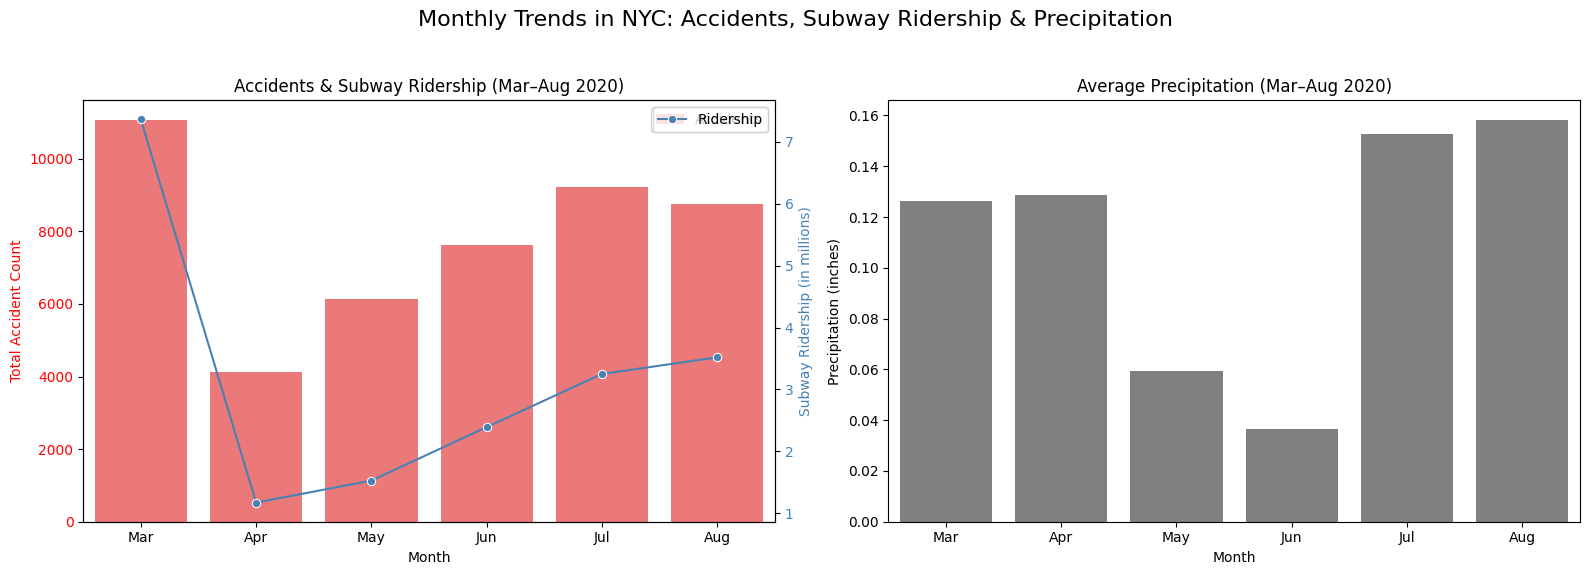

In [13]:
weather['Date'] = pd.to_datetime(weather['Date'])
mta['Date'] = pd.to_datetime(mta['Date'])

# --- Data Preparation ---
# Ensure date columns are datetime objects
accidents['CRASH DATE'] = pd.to_datetime(accidents['CRASH DATE'])
mta['Date'] = pd.to_datetime(mta['Date'])
weather['Date'] = pd.to_datetime(weather['Date'])

# Filter each dataset for March–August 2020
acc_2020 = accidents[(accidents['CRASH DATE'].dt.year == 2020) &
                     (accidents['CRASH DATE'].dt.month >= 3) &
                     (accidents['CRASH DATE'].dt.month <= 8)]
mta_2020 = mta[(mta['Date'].dt.year == 2020) &
               (mta['Date'].dt.month >= 3) &
               (mta['Date'].dt.month <= 8)]
weather_2020 = weather[(weather['Date'].dt.year == 2020) &
                       (weather['Date'].dt.month >= 3) &
                       (weather['Date'].dt.month <= 8)]

# Create a 'Month' column in each dataset
acc_2020['Month'] = acc_2020['CRASH DATE'].dt.month
mta_2020['Month'] = mta_2020['Date'].dt.month
weather_2020['Month'] = weather_2020['Date'].dt.month

# --- Aggregation ---
# Total accident count per month
accidents_by_month = acc_2020.groupby('Month').size().reset_index(name='Accident_Count')

# Total subway ridership per month (using sum)
mta_by_month = mta_2020.groupby('Month')['Subways: Total Estimated Ridership'].sum().reset_index(name='Ridership')

# Average precipitation per month
weather_by_month = weather_2020.groupby('Month')['Precipitation (in) Total'].mean().reset_index(name='Avg_Precipitation')

# Merge the aggregated dataframes (inner join keeps only months present in all)
monthly_df = accidents_by_month.merge(mta_by_month, on='Month', how='inner')\
                               .merge(weather_by_month, on='Month', how='inner')
monthly_df = monthly_df.sort_values(by='Month')

# Create month name mapping manually (for months 3-8)
month_map = {3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug'}
monthly_df['MonthName'] = monthly_df['Month'].map(month_map)

# Scale ridership to millions (dividing by 1E7)
monthly_df['Ridership_Millions'] = monthly_df['Ridership'] / 1e7

# --- Visualization ---
# Create a figure with two subplots: one for Accident Count & Ridership and one for Precipitation.
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(16,6), sharex=True)

# Left Subplot: Accident Count (bar plot) & Ridership (line plot on twin axis)
sns.barplot(data=monthly_df, x='MonthName', y='Accident_Count', ax=ax1,
            color='red', alpha=0.6, label='Accidents')
ax1.set_ylabel('Total Accident Count', color='red')
ax1.tick_params(axis='y', labelcolor='red')
ax1.set_xlabel('Month')

# Twin axis for Ridership
ax1b = ax1.twinx()
sns.lineplot(data=monthly_df, x='MonthName', y='Ridership_Millions', marker='o', ax=ax1b,
             color='steelblue', label='Ridership')
ax1b.set_ylabel('Subway Ridership (in millions)', color='steelblue')
ax1b.tick_params(axis='y', labelcolor='steelblue')
ax1.set_title('Accidents & Subway Ridership (Mar–Aug 2020)')

# Right Subplot: Average Precipitation as a bar plot
sns.barplot(data=monthly_df, x='MonthName', y='Avg_Precipitation', ax=ax2, color='gray')
ax2.set_title('Average Precipitation (Mar–Aug 2020)')
ax2.set_ylabel('Precipitation (inches)')
ax2.set_xlabel('Month')

plt.suptitle('Monthly Trends in NYC: Accidents, Subway Ridership & Precipitation', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

## Orator: Sydney Mason

### Q1: "Are there weather patterns that lead to more accidents/ increased ridership on the MTA?  (Compare different types and levels of precipitation)

  Precipitation Type  Average Accidents Per Day Precipitation
0      Likely Frozen                               598.000000
1               None                               312.748252
2  Not Likely Frozen                               298.577320


Text(0.5, 1.0, 'Accidents Per Day Grouped by Precipitation')

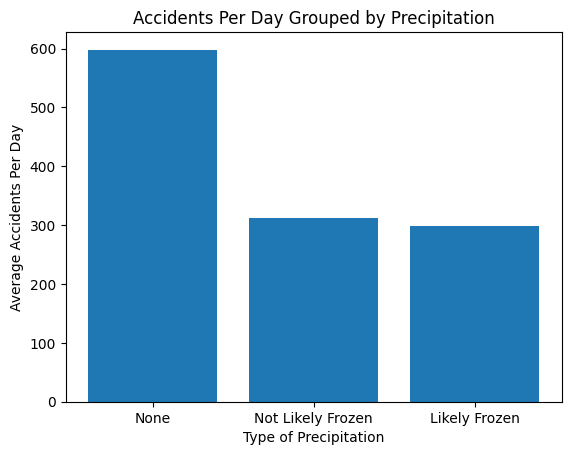

In [14]:
accidents_per_day = nyc_accidents.groupby(['CRASH DATE']).size().reset_index(name='Accidents Per Day') #grouping accidents per day by date
weather['Precipitation Type'] = np.nan #creating a precipitation type column
weather.loc[weather['Precipitation (in) Total'] == 0.00, 'Precipitation Type'] = 'None'
weather.loc[(weather['Precipitation (in) Total'] > 0.00), 'Precipitation Type'] = 'Not Likely Frozen'
weather.loc[(weather['Temperature (°F) Avg'] < 35.0) & (weather['Precipitation Type'] != 'None'), 'Precipitation Type'] = 'Likely Frozen' # cutoff for frozen temps
weather['Accidents Per Day'] = accidents_per_day['Accidents Per Day']
average_accidents_weather = weather.groupby('Precipitation Type')['Accidents Per Day'].mean().reset_index(name='Average Accidents Per Day Precipitation') #averaged accidents per day by precip
print(average_accidents_weather.head())
figsize= (10,10)
x= average_accidents_weather['Precipitation Type'].iloc[[1,2,0]]
y=average_accidents_weather['Average Accidents Per Day Precipitation']
plt.ylabel("Average Accidents Per Day")
plt.xlabel("Type of Precipitation")
plt.bar(x,y)
plt.title("Accidents Per Day Grouped by Precipitation")

### Q2: "Does MTA density in a borough affect the overall occurrence of traffic accidents in an area?"

Text(0.5, 1.0, 'Average Number of Accidents Per Day and Subway Density Per Square Mile per Borough')

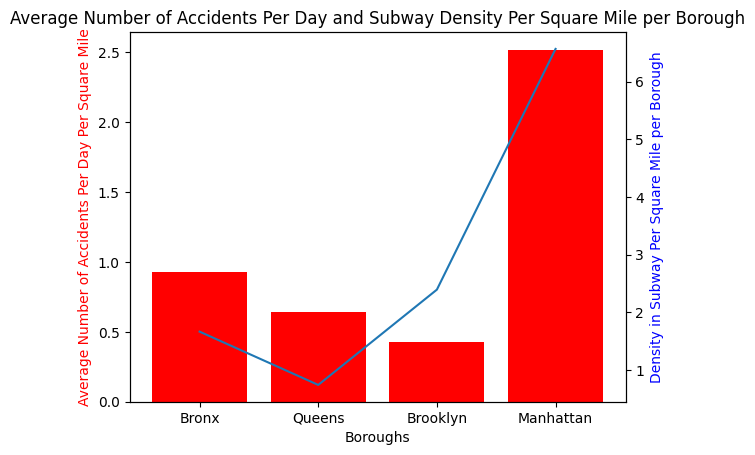

In [15]:

nyc_accidents.dropna(subset=['BOROUGH'], inplace=True) #cleaning out rows without boroughs
accidents_per_day_borough = nyc_accidents.groupby(['CRASH DATE', 'BOROUGH']).size().reset_index(name='ACCIDENT_COUNT')
average_accidents_per_borough = accidents_per_day_borough.groupby('BOROUGH')['ACCIDENT_COUNT'].mean().reset_index()
average_accidents_only_included= average_accidents_per_borough[0:4]
average_accidents_only_included1= average_accidents_only_included.iloc[[0, 3, 1, 2]] #keeping order the same throughout 
data = {'Borough': ['Bronx', 'Queens', 'Brooklyn', 'Manhattan'],
        'Subway Stations Number': [70, 81, 170, 151],#wikipedia data https://en.wikipedia.org/wiki/New_York_City_Subway_stations#List_of_stations 
       'Area (Miles)': [42, 109, 71, 23] } #geographic data on burroughs https://www.ncesc.com/geographic-faq/how-many-square-miles-are-the-5-boroughs-of-new-york-city/
df = pd.DataFrame(data)
df['Density']= (df['Subway Stations Number']/ df['Area (Miles)']) # a density calc based on sq miles
fig=plt.figure()
x= df['Borough']
y=average_accidents_only_included1['ACCIDENT_COUNT']/ df['Area (Miles)']
y1= df['Density']
ax=fig.add_subplot()
ax1= plt.bar(x,y, color= 'r')
ax2= ax.twinx()
ax2.plot(x, y1)
ax.set_xlabel('Boroughs')
ax.set_ylabel('Average Number of Accidents Per Day Per Square Mile', color='r')
ax2.set_ylabel('Density in Subway Per Square Mile per Borough', color='b')
plt.title('Average Number of Accidents Per Day and Subway Density Per Square Mile per Borough')

## Deliverer: Andrew Jensen

### Q1: What NYC boroughs have the highest amounts of crashes, and can the breakdown of vehicle type expain why some boroughs may have more crashes? 

BOROUGH
BROOKLYN         16907
QUEENS           14017
BRONX             9417
MANHATTAN         7353
STATEN ISLAND     1446
Name: count, dtype: int64


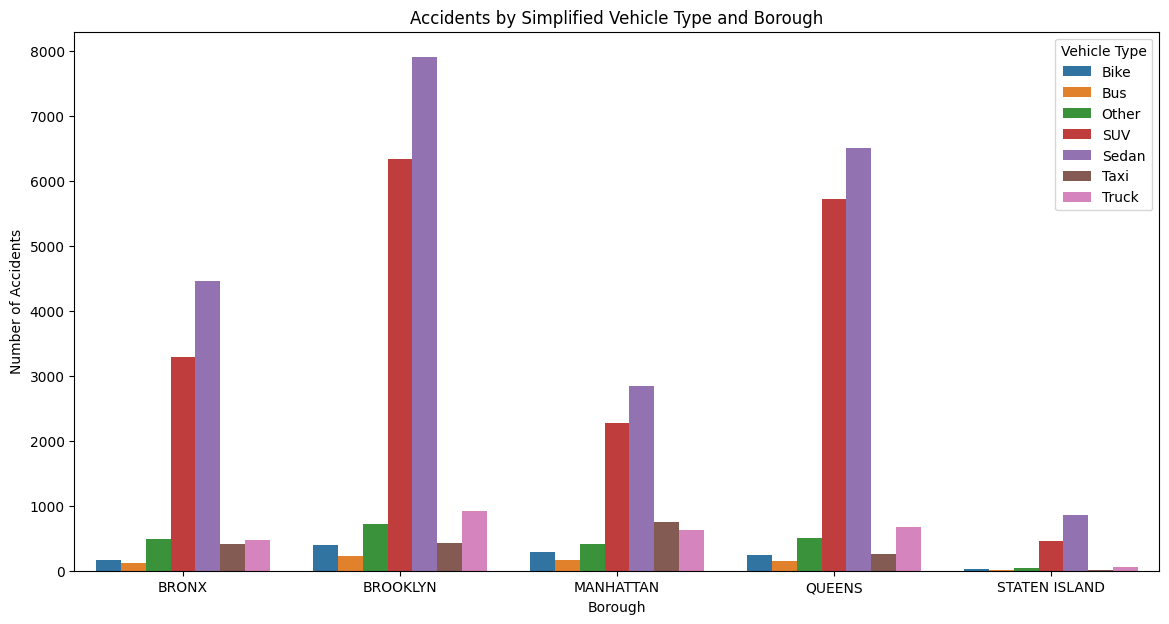

In [16]:
accidents = pd.read_csv("/work/NYC Accidents 2020.csv")
#clean up the data
accidents["CRASH DATE"] = pd.to_datetime(accidents["CRASH DATE"])
accidents["CRASH TIME"] = pd.to_datetime(accidents["CRASH TIME"])
accidents["BOROUGH"] = accidents["BOROUGH"].astype("category")
accidents["VEHICLE TYPE CODE 1"] = accidents["VEHICLE TYPE CODE 1"].astype("category")
accidents["VEHICLE TYPE CODE 2"] = accidents["VEHICLE TYPE CODE 2"].astype("category")
accidents["VEHICLE TYPE CODE 3"] = accidents["VEHICLE TYPE CODE 3"].astype("category")
accidents["VEHICLE TYPE CODE 4"] = accidents["VEHICLE TYPE CODE 4"].astype("category")
accidents["VEHICLE TYPE CODE 5"] = accidents["VEHICLE TYPE CODE 5"].astype("category")
accidents_clean = accidents.dropna(subset=["BOROUGH"])
print(accidents_clean["BOROUGH"].value_counts())

#for the vehicle types, many are spelled the same way but upper or lower case, making classification difficult
#created a maping system to correctly associate vehicle types within the column
vehicle_type_mapping = {
    'Sedan': 'Sedan',
    'Station Wagon/Sport Utility Vehicle': 'SUV',
    'SUV': 'SUV',
    'Pick-up Truck': 'Truck',
    'Box Truck' : 'Truck',
    'Truck': 'Truck',
    'Motorcycle': 'Bike',
    'Van': 'Other',
    'Other': 'Other',
    'Hatchback': 'Sedan',
    'Coupe': 'Sedan',
    'Wagon': 'SUV',
    'Taxi' : 'Taxi',
    'Bus' : 'Bus',
    '4 dr sedan' : 'Sedan',
    'Tractor Truck Diesel' : 'Truck',
    'Bike' : 'Bike',
    'E-Scooter': 'Bike',
    'Van' : 'Truck',
    'Tractor Truck Diesel' : 'Truck'
}

#mapping the vehicle types
accidents_clean['SIMPLE_VEHICLE_TYPE'] = accidents_clean['VEHICLE TYPE CODE 1'].map(vehicle_type_mapping)
accidents_clean['SIMPLE_VEHICLE_TYPE'].fillna('Other', inplace=True)

vehicle_type_counts = accidents_clean.groupby(['BOROUGH', 'SIMPLE_VEHICLE_TYPE']).size().reset_index(name='ACCIDENT_COUNT')

#plotting the graph
plt.figure(figsize=(14, 7))

sns.barplot(x='BOROUGH', y='ACCIDENT_COUNT', hue='SIMPLE_VEHICLE_TYPE', data=vehicle_type_counts)

plt.title("Accidents by Simplified Vehicle Type and Borough")
plt.xlabel("Borough")
plt.ylabel("Number of Accidents")
plt.legend(title='Vehicle Type', loc='upper right')

plt.show()# Code here for Q1

### Q2:  Can we use weather forecasts to predict changes in subway ridership and accident frequency?

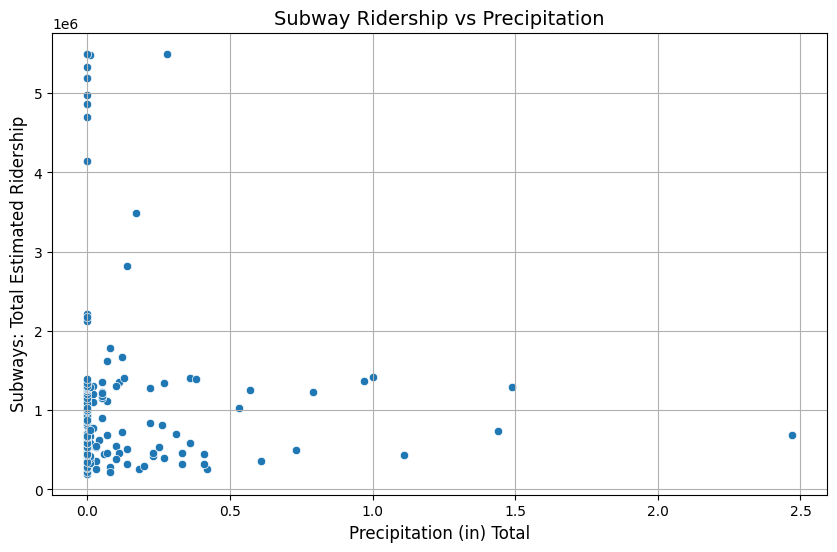

Correlation between Precipitation and Subway Ridership: -0.04


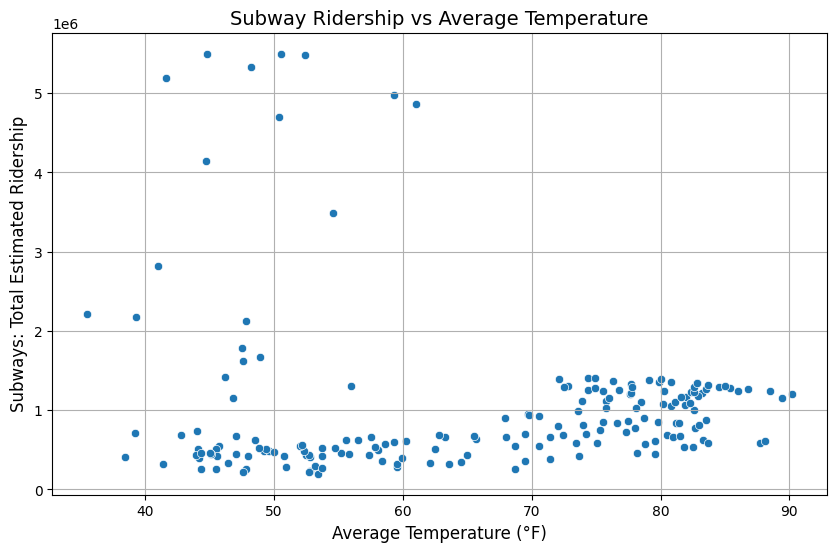

Correlation between Average Temperature and Subway Ridership: -0.10


In [17]:
# Code here for Q2
weather = pd.read_csv('NYC_weather_data_Jan-Aug2020.csv')
ridership = pd.read_csv('MTA_Daily_Ridership.csv')
merged = pd.merge(ridership,weather, on='Date', how='inner')
merged['Date'] = pd.to_datetime(merged['Date'])
merged.set_index('Date', inplace=True)

#plotting graph for ridership vs precipitation
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Precipitation (in) Total', y='Subways: Total Estimated Ridership', data=merged)
plt.title('Subway Ridership vs Precipitation', fontsize=14)
plt.xlabel('Precipitation (in) Total', fontsize=12)
plt.ylabel('Subways: Total Estimated Ridership', fontsize=12)
plt.grid(True)
plt.show()

#calculating correlation
correlation = merged['Precipitation (in) Total'].corr(merged['Subways: Total Estimated Ridership'])
print(f"Correlation between Precipitation and Subway Ridership: {correlation:.2f}")

#temperature vs estimated ridership
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Temperature (°F) Avg', y='Subways: Total Estimated Ridership', data=merged)
plt.title('Subway Ridership vs Average Temperature', fontsize=14)
plt.xlabel('Average Temperature (°F)', fontsize=12)
plt.ylabel('Subways: Total Estimated Ridership', fontsize=12)
plt.grid(True)
plt.show()

#calculating correlation
correlation_temp = merged['Temperature (°F) Avg'].corr(merged['Subways: Total Estimated Ridership'])
print(f"Correlation between Average Temperature and Subway Ridership: {correlation_temp:.2f}")

## Follow-up Questions

### New Questions Based Off Initial Investigation

- Q1: Can we predict alcohol consumption related crashes based on time of day, day of the week, borough, vehicle type, and severity of crash?
- Q2: Can we predict accident severity based on precipitation, mta ridership, humidity, time of day, and the type of vehicle that was in the accident?
- Q3: Can we predict the number of accidents that will occur on a given day given the weather of that day and the ridership?
- Q4: Can we predict whether a day is a high subway ridership day (defined as above the median ridership) using daily accident counts and weather conditions? In other words, can a classification model accurately predict high vs. low ridership days using the following variables: accident count, temperature, precipitation (in), humidity (%) average?

### Investigation of Follow-up Questions

Our group decided to further investigate question 1 and question 4.

# Q1:  Can we predict alcohol consumption related crashes based on time of day, day of the week, borough, vehicle type, and severity of crash?

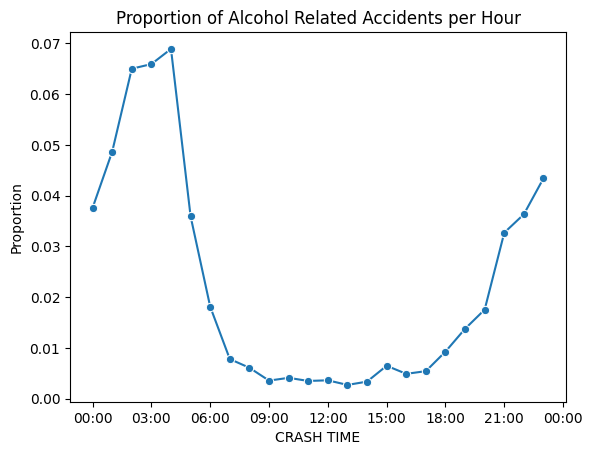

In [18]:
#Define cols for VIF calculation later
def convert_to_time_period(hour):
    if 6 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 18:
        return 'Afternoon'
    elif 18 <= hour < 21:
        return 'Evening'
    else:
        return 'Night'

burrough_inc['IsSevere'] = (burrough_inc['NUMBER OF PERSONS INJURED']>=4)|(burrough_inc['NUMBER OF PERSONS KILLED']>=2)
burrough_inc['IsAlcohol'] = (burrough_inc['CONTRIBUTING FACTOR VEHICLE 1'] == 'Alcohol Involvement') | (burrough_inc['CONTRIBUTING FACTOR VEHICLE 2'] == 'Alcohol Involvement') | (burrough_inc['CONTRIBUTING FACTOR VEHICLE 3'] == 'Alcohol Involvement')| (burrough_inc['CONTRIBUTING FACTOR VEHICLE 4'] == 'Alcohol Involvement')
burrough_inc['Hour'] = pd.to_datetime(burrough_inc['CRASH TIME'],format='%H:%M').dt.hour
burrough_inc['Time_Of_Day'] = burrough_inc['Hour'].apply(convert_to_time_period)

#define alcohol related crashes as any crash where a contributing factor was 'Alcohol Involvement'
alcohol_related = burrough_inc[(burrough_inc['CONTRIBUTING FACTOR VEHICLE 1'] == 'Alcohol Involvement') | (burrough_inc['CONTRIBUTING FACTOR VEHICLE 2'] == 'Alcohol Involvement') | (burrough_inc['CONTRIBUTING FACTOR VEHICLE 3'] == 'Alcohol Involvement')| (burrough_inc['CONTRIBUTING FACTOR VEHICLE 4'] == 'Alcohol Involvement')]
alcohol_prop_df= get_proportion_df(alcohol_related,'CRASH TIME',total_crashes_every_hour,True)


plt.title('Proportion of Alcohol Related Accidents per Hour');


sns.lineplot(y='Proportion',x='CRASH TIME',data=alcohol_prop_df,marker='o')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))


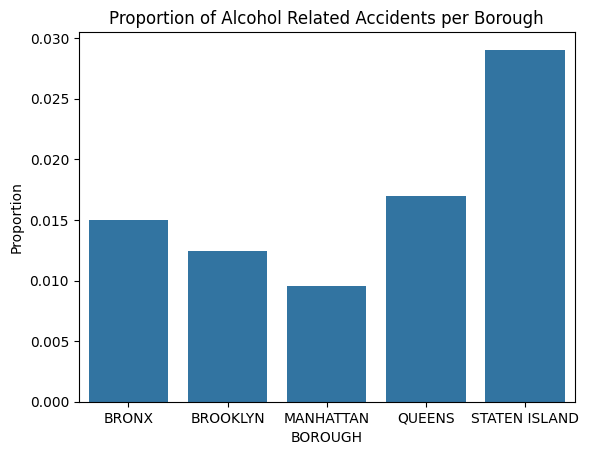

In [19]:
#Borough
alcohol_related_by_borough = get_proportion_df(alcohol_related,'BOROUGH',total_crashes_per_borough,False) 
sns.barplot(x='BOROUGH',y='Proportion',data=alcohol_related_by_borough)
plt.title('Proportion of Alcohol Related Accidents per Borough');

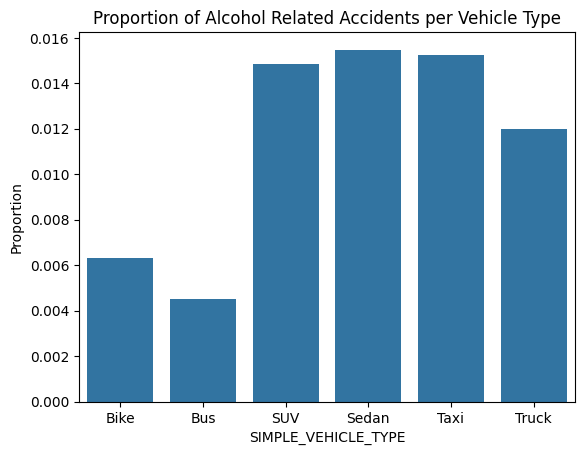

In [20]:
#Vehicle Type
burrough_inc['SIMPLE_VEHICLE_TYPE'] = burrough_inc['VEHICLE TYPE CODE 1'].map(vehicle_type_mapping)

total_crashes_per_vehicle_type = get_totals(burrough_inc,'SIMPLE_VEHICLE_TYPE',False)

alcohol_related_with_vehicles = burrough_inc[(burrough_inc['CONTRIBUTING FACTOR VEHICLE 1'] == 'Alcohol Involvement') | (burrough_inc['CONTRIBUTING FACTOR VEHICLE 2'] == 'Alcohol Involvement') | (burrough_inc['CONTRIBUTING FACTOR VEHICLE 3'] == 'Alcohol Involvement')| (burrough_inc['CONTRIBUTING FACTOR VEHICLE 4'] == 'Alcohol Involvement')]

alcohol_related_with_vehicles= get_proportion_df(alcohol_related_with_vehicles,'SIMPLE_VEHICLE_TYPE',total_crashes_per_vehicle_type,False)

sns.barplot(x='SIMPLE_VEHICLE_TYPE',y='Proportion',data=alcohol_related_with_vehicles)
plt.title('Proportion of Alcohol Related Accidents per Vehicle Type');

Average number of people injured with alcohol: 0.4950071326676177
Average number of people injured without alcohol: 0.3358863725510436


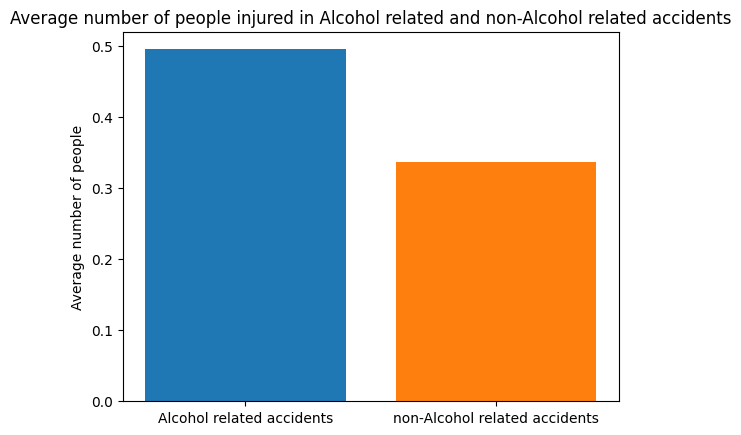

In [21]:
#Accident Severity
non_alcohol_related = burrough_inc[~((burrough_inc['CONTRIBUTING FACTOR VEHICLE 1'] == 'Alcohol Involvement') | (burrough_inc['CONTRIBUTING FACTOR VEHICLE 2'] == 'Alcohol Involvement') | (burrough_inc['CONTRIBUTING FACTOR VEHICLE 3'] == 'Alcohol Involvement')| (burrough_inc['CONTRIBUTING FACTOR VEHICLE 4'] == 'Alcohol Involvement'))]

alcohol_related_by_severity = alcohol_related['NUMBER OF PERSONS INJURED']
avg_num_of_injured_alcohol = alcohol_related_by_severity.mean()
avg_num_of_injured_nonAlcohol = non_alcohol_related['NUMBER OF PERSONS INJURED'].mean()

print('Average number of people injured with alcohol: ' + str(avg_num_of_injured_alcohol))
print('Average number of people injured without alcohol: ' + str(avg_num_of_injured_nonAlcohol))
plt.bar('Alcohol related accidents',avg_num_of_injured_alcohol)
plt.bar('non-Alcohol related accidents',avg_num_of_injured_nonAlcohol)
plt.title('Average number of people injured in Alcohol related and non-Alcohol related accidents')
plt.ylabel('Average number of people');


Proportion of severe alcohol related accidents: 0.012838801711840228
Proportion of severe non-alcohol related accidents: 0.005470798323664815


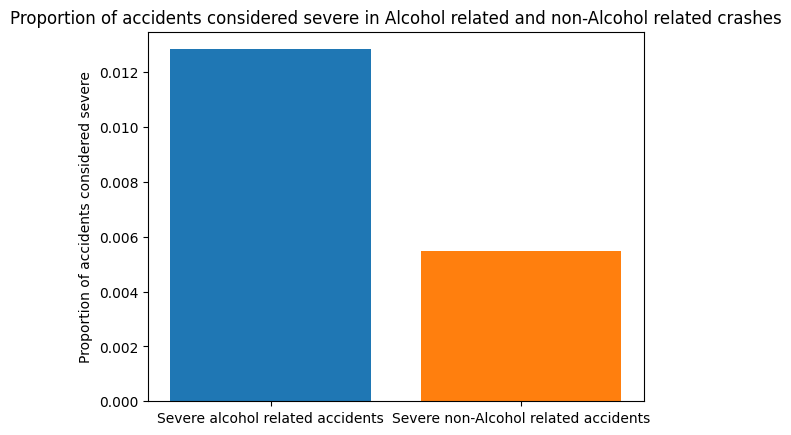

In [22]:
# Accident Serverity Continued
#proportion of high_severity accidents 

severe_alcohol_related = alcohol_related[(alcohol_related['NUMBER OF PERSONS INJURED']>=4) | (alcohol_related['NUMBER OF PERSONS KILLED']>=2)]
severe_non_alcohol_related = non_alcohol_related[(non_alcohol_related['NUMBER OF PERSONS INJURED']>=4) |(non_alcohol_related['NUMBER OF PERSONS KILLED']>=2)]

prop_severe_alcohol_related = severe_alcohol_related.shape[0]/alcohol_related.shape[0]
prop_severe_non_alcohol_related = severe_non_alcohol_related.shape[0]/non_alcohol_related.shape[0]

print('Proportion of severe alcohol related accidents: ' + str(prop_severe_alcohol_related))
print('Proportion of severe non-alcohol related accidents: ' + str(prop_severe_non_alcohol_related))

plt.bar('Severe alcohol related accidents',prop_severe_alcohol_related)
plt.bar('Severe non-Alcohol related accidents',prop_severe_non_alcohol_related)
plt.title('Proportion of accidents considered severe in Alcohol related and non-Alcohol related crashes')
plt.ylabel('Proportion of accidents considered severe');


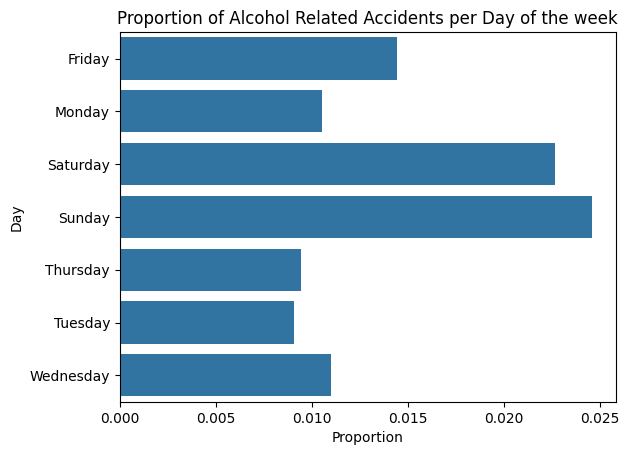

In [23]:
#Alchohol Related Accidents by day of the week

#Format data to use day of the week names.
alcohol_related_by_day= pd.DataFrame()
alcohol_related_by_day['Day'] = pd.to_datetime(alcohol_related['CRASH DATE']).dt.day_name()
burrough_inc['Day'] = pd.to_datetime(burrough_inc['CRASH DATE']).dt.day_name()

#Compute the proportion of accidents that occured on each day of the week that were alcohol related.
total_accidents_per_day = get_totals(burrough_inc,'Day')
alcohol_related_by_day = get_proportion_df(alcohol_related_by_day,'Day',total_accidents_per_day,False)
sns.barplot(x='Proportion',y='Day',data=alcohol_related_by_day,orient='h')
plt.title('Proportion of Alcohol Related Accidents per Day of the week');

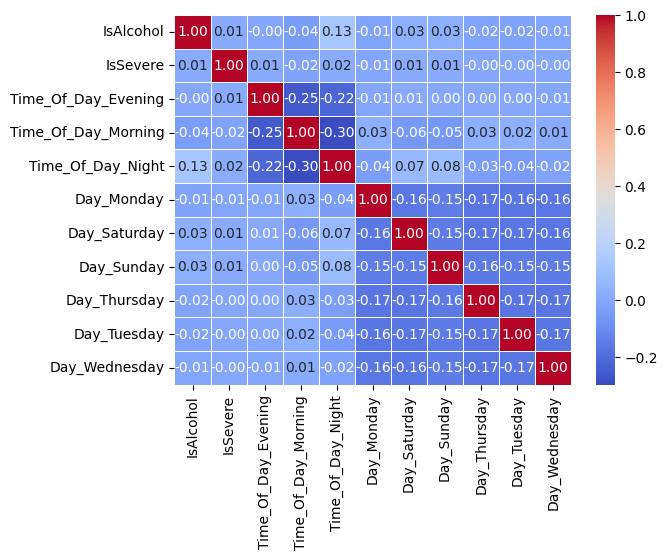

In [24]:
from patsy import dmatrix
from statsmodels.stats.outliers_influence import variance_inflation_factor

#Create relevant Df for VIF and corr

def get_corr_and_vif(data,columns,ifBorough=False,showHeatmap=True,showVIF=False):
    """
    Calculate the correlation matrix and VIF for a given dataframe and list of columns

    Parameters
    ----------
    data : pandas.DataFrame
        The dataframe to calculate the correlation matrix and VIF for
    columns : list
        The list of columns to calculate the correlation matrix and VIF for
    ifBorough : bool
        Whether Borough is included in the columns list
    Returns
    -------
        Prints the correlation matrix as a heatmap and VIF for the given dataframe and list of columns

    """
    cols_to_check = data[columns].copy()
    data_encoded = pd.get_dummies(cols_to_check, drop_first=True)
    if ifBorough:
        data_encoded.rename(columns={'BOROUGH_STATEN ISLAND':'BOROUGH_STATEN_ISLAND'}, inplace=True)

    if showHeatmap: 
        corr_matrix = data_encoded.corr()
        sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
    
    if showVIF:
        X = dmatrix("0 + " + " + ".join(data_encoded.columns), data_encoded, return_type='dataframe')

        # Calculating VIF for each feature
        vif_data = pd.DataFrame()
        vif_data['Feature'] = X.columns
        vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

        print(vif_data)

cols1 = ['IsAlcohol','IsSevere','Time_Of_Day','Day']
cols2 = ['IsAlcohol','SIMPLE_VEHICLE_TYPE']
cols3 = ['IsAlcohol','BOROUGH']
all_cols = ['IsAlcohol','IsSevere','Time_Of_Day','Day','SIMPLE_VEHICLE_TYPE','BOROUGH']

get_corr_and_vif(burrough_inc,cols1)
#Heatmap for columns: 'IsAlcohol','IsSevere','Time_Of_Day','Day']

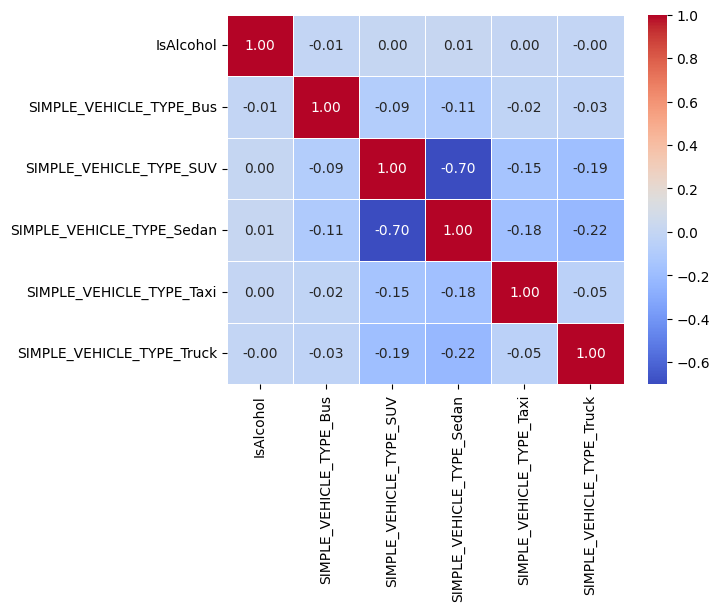

In [25]:
#Heatmap for columns: 'IsAlcohol','SIMPLE_VEHICLE_TYPE']
get_corr_and_vif(burrough_inc,cols2)


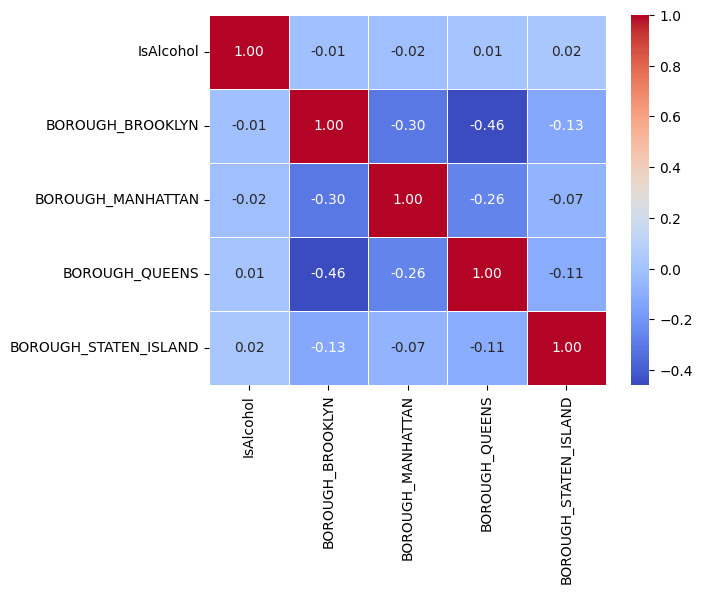

In [26]:
#Heatmap for columns: 'IsAlcohol','BOROUGH'
get_corr_and_vif(burrough_inc,cols3,True)


In [27]:
#VIF table for all columns analyzed above.
get_corr_and_vif(burrough_inc,all_cols,True,showHeatmap=False,showVIF=True)

                              Feature        VIF
0                    IsAlcohol[False]  25.682915
1                     IsAlcohol[True]   1.410366
2                    IsSevere[T.True]   1.001757
3         Time_Of_Day_Evening[T.True]   1.191450
4         Time_Of_Day_Morning[T.True]   1.243726
5           Time_Of_Day_Night[T.True]   1.256029
6                  Day_Monday[T.True]   1.596501
7                Day_Saturday[T.True]   1.609866
8                  Day_Sunday[T.True]   1.538258
9                Day_Thursday[T.True]   1.634015
10                Day_Tuesday[T.True]   1.610231
11              Day_Wednesday[T.True]   1.604968
12    SIMPLE_VEHICLE_TYPE_Bus[T.True]   1.191259
13    SIMPLE_VEHICLE_TYPE_SUV[T.True]   4.154015
14  SIMPLE_VEHICLE_TYPE_Sedan[T.True]   4.297979
15   SIMPLE_VEHICLE_TYPE_Taxi[T.True]   1.518944
16  SIMPLE_VEHICLE_TYPE_Truck[T.True]   1.750164
17           BOROUGH_BROOKLYN[T.True]   1.836831
18          BOROUGH_MANHATTAN[T.True]   1.534949
19             BOROU

# Q2:   Can we predict whether a day is a high subway ridership day (defined as above the median ridership) using daily accident counts and weather conditions? In other words, can a classification model accurately predict high vs. low ridership days using the following variables: accident count, temperature, precipitation (in), humidity (%) average?

Correlation Matrix:
                          Accident_Count  Temperature (°F) Avg  \
Accident_Count                  1.000000              0.225022   
Temperature (°F) Avg            0.225022              1.000000   
Precipitation (in) Total       -0.018606             -0.011818   
Humidity (%) Avg               -0.020263              0.066162   
High_Ridership                  0.672628              0.410130   

                          Precipitation (in) Total  Humidity (%) Avg  \
Accident_Count                           -0.018606         -0.020263   
Temperature (°F) Avg                     -0.011818          0.066162   
Precipitation (in) Total                  1.000000          0.210881   
Humidity (%) Avg                          0.210881          1.000000   
High_Ridership                            0.017298          0.036059   

                          High_Ridership  
Accident_Count                  0.672628  
Temperature (°F) Avg            0.410130  
Precipitation (in) To

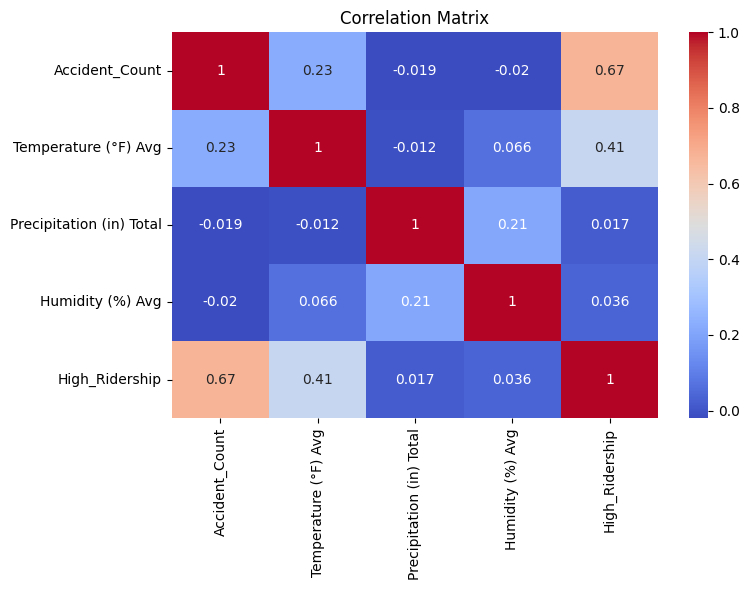

VIF Table:
                    Feature        VIF
0                     const  37.248753
1            Accident_Count   1.054798
2      Temperature (°F) Avg   1.059513
3  Precipitation (in) Total   1.047355
4          Humidity (%) Avg   1.052907

SVM Classifier Results:
Accuracy: 0.8181818181818182
Confusion Matrix:
 [[21 10]
 [ 0 24]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.68      0.81        31
           1       0.71      1.00      0.83        24

    accuracy                           0.82        55
   macro avg       0.85      0.84      0.82        55
weighted avg       0.87      0.82      0.82        55



In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

# ---------------------------
# Data Preparation and Aggregation
# ---------------------------
# Convert date columns to datetime
accidents['CRASH DATE'] = pd.to_datetime(accidents['CRASH DATE'])
weather['Date'] = pd.to_datetime(weather['Date'])
mta['Date'] = pd.to_datetime(mta['Date'])

# Aggregate accident data by day: count accidents per day
daily_accidents = accidents.groupby(accidents['CRASH DATE'].dt.date).size().reset_index(name='Accident_Count')
daily_accidents['Date'] = pd.to_datetime(daily_accidents['CRASH DATE'])
daily_accidents.drop('CRASH DATE', axis=1, inplace=True)

# Aggregate weather data by day.
# (If multiple records per day exist, compute mean for temperature/humidity and sum for precipitation.)
daily_weather = weather.groupby(weather['Date'].dt.date).agg({
    'Temperature (°F) Avg': 'mean',
    'Precipitation (in) Total': 'sum',
    'Humidity (%) Avg': 'mean'
}).reset_index()
daily_weather['Date'] = pd.to_datetime(daily_weather['Date'])

# Use MTA data as provided (assumed daily records)
daily_mta = mta[['Date', 'Subways: Total Estimated Ridership']].copy()

# Merge datasets on Date (inner join ensures all three datasets share the same days)
df_daily = daily_accidents.merge(daily_weather, on='Date', how='inner')
df_daily = df_daily.merge(daily_mta, on='Date', how='inner')

# Create a binary target variable: High_Ridership = 1 if daily ridership is above the median; else 0.
median_ridership = df_daily['Subways: Total Estimated Ridership'].median()
df_daily['High_Ridership'] = (df_daily['Subways: Total Estimated Ridership'] > median_ridership).astype(int)

# ---------------------------
# Exploratory Visualizations
# ---------------------------
# 1. Correlation Matrix to examine relationships between features and the target
features = ['Accident_Count', 'Temperature (°F) Avg', 'Precipitation (in) Total', 'Humidity (%) Avg']
corr_matrix = df_daily[features + ['High_Ridership']].corr()
print("Correlation Matrix:")
print(corr_matrix)
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.tight_layout()
plt.show()

# 2. VIF Table to check for multicollinearity among the features
X_vif = df_daily[features]
X_vif_const = sm.add_constant(X_vif)
vif_data = pd.DataFrame()
vif_data["Feature"] = X_vif_const.columns
vif_data["VIF"] = [variance_inflation_factor(X_vif_const.values, i) for i in range(X_vif_const.shape[1])]
print("VIF Table:")
print(vif_data)

# ---------------------------
# Machine Learning Model: SVM Classifier
# ---------------------------
# Feature Scaling: Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_daily[features])
X_model = pd.DataFrame(X_scaled, columns=features)
y_model = df_daily['High_Ridership']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_model, y_model, test_size=0.3, random_state=42)

# Build an SVM classifier (using a radial basis function kernel)
svm_clf = SVC(kernel='rbf', probability=True, random_state=42)
svm_clf.fit(X_train, y_train)

# Predict on the test set and evaluate the model
y_pred = svm_clf.predict(X_test)
print("\nSVM Classifier Results:")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

# ---------------------------
# Optional: Visualization of Decision Boundaries (if reducing to 2 features)
# (Not included here since we have 4 features; focus remains on the correlation and VIF visualizations.)

In [29]:
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import pandas as pd

def train_model(model):
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(df_daily[features])
    X_model = pd.DataFrame(X_scaled, columns=features)
    y_model = df_daily['High_Ridership']

    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X_model, y_model, test_size=0.3, random_state=42)

    # Build an SVM classifier (using a radial basis function kernel)
    model.fit(X_train, y_train)

    # Predict on the test set and evaluate the model
    y_pred = model.predict(X_test)
    print(f"{type(model).__name__} Classifier Results:")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print("Classification Report:\n", classification_report(y_test, y_pred))

# === Sample Usage ===

# Baseline
baseline_model = DummyClassifier(strategy='most_frequent')
train_model(baseline_model)

# Decision Tree
dt = DecisionTreeClassifier(max_depth=5)
train_model(dt)

# Logistic Regression
logreg = LogisticRegression(max_iter=1000)
train_model(logreg)

# SVM with RBF Kernel
svm_rbf = SVC(kernel='rbf', probability=True)
train_model(svm_rbf)

# Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
train_model(rf)

DummyClassifier Classifier Results:
Accuracy: 0.43636363636363634
Confusion Matrix:
 [[ 0 31]
 [ 0 24]]
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        31
           1       0.44      1.00      0.61        24

    accuracy                           0.44        55
   macro avg       0.22      0.50      0.30        55
weighted avg       0.19      0.44      0.27        55

DecisionTreeClassifier Classifier Results:
Accuracy: 0.8
Confusion Matrix:
 [[22  9]
 [ 2 22]]
Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.71      0.80        31
           1       0.71      0.92      0.80        24

    accuracy                           0.80        55
   macro avg       0.81      0.81      0.80        55
weighted avg       0.83      0.80      0.80        55

LogisticRegression Classifier Results:
Accuracy: 0.8363636363636363
Confusion Matrix:
 [[22  9]
 [ 

## Summary

In our initial investigation we explored several aspects of subway ridership, accident data, and weather conditions across New York City in 2020. Our analysis revealed several trends in accidents and subway ridership. Serious crashes occurred disproportionately late at night, despite overall crash numbers being lower during those hours. Weather’s impact on subway ridership was also notable. While ridership increased on rainy weekdays, it did not follow the same trend on weekends, indicating that commuters are more likely to rely on public transit for work-related travel in bad weather but not on weekends. Additionally, colder days (below 60°F) were associated with higher subway ridership, but no high-ridership days occurred when temperatures were above 70°F. Statistical tests showed no significant difference in accident rates between fair and poor weather conditions, despite an initial trend suggesting more accidents in bad weather. We also looked to see if there were differences in the number of accidents on average per square mile based on MTA density per square mile in different boroughs.  We found that although Manhattan had the highest density of subways it also had the highest number of accidents per square mile, whereas other boroughs had lower density of subways but also lower accident rates. Looking at the vehicle breakdown by borough, Brooklyn and Queens saw significantly more SUV and Sedan crashes, while Manhattan had the highest number of taxi-related accidents. These findings raise further questions, such as how specific weather conditions influence commuter choices, why serious crashes are more common at night (maybe relating to alcohol), and whether certain boroughs should require safety interventions based on vehicle type and accident severity trends.

In Question 1 we saw some interesting trends within the data related to Alcohol related accidents. We saw that alcohol related accidents occur disproportionately late at night compared to the middle of the day and they also primarily occur on Saturday and Sunday. This aligned with our expectations because most people would probably go out drinking on those days so it makes sense that we would see a higher proportion of accidents on weekends than weekdays as well as late at night. Another discrepancy we saw was that a much higher proportion of Alcohol related accidents were classified as severe based compared to non-alcohol related accidents as well as the average number of people injured in alcohol related accidents was higher than in non-alcohol accidents. Lastly, we created plot showing the proportion of accidents that were alcohol related in each borough and for each vehicle type and we saw that Staten Island had a much larger proportion of alcohol related accidents compared to the other boroughs, and that bikes and buses were involved in a smaller proportion of alcohol related accidents compared to all other vehicle types. What makes this interesting is that we see some things that point to alcohol related accidents having distinct features compared to accidents of other types such as primarily occurring at night or generally being considered severe compared to other accidents, so these are features we can look at trying to build a model for and trying to figure out whether we can predict whether an accident was alcohol related. Based on the VIF tables it doesn't seem like we have collinearity issues within any of the variables and the heatmaps show that we don't have very large correlations between a lot of the variables which could be a concern if we were to pick a linear model as there doesn't seem to be a clear linear relationship between our features. Because of this we will probably focus on non-linear machine learning models for this algorithm. For our second question, the correlation matrix shows that the total number of accidents on a day is strongly and positively related to high subway ridership (with a correlation coefficient of about 0.67). This means that days with more accidents tend to have higher ridership. The average temperature also has a moderate positive relationship with high ridership (approximately 0.41), so warmer days are often busier on the subway. On the other hand, daily precipitation and humidity have almost no correlation with high ridership, so they do not play a major role in determining whether a day has above median ridership. We then used a SVM classifier to predict whether a day is high ridership based on these features, and the model achieved an overall accuracy of about 82%. The confusion matrix shows that the classifier correctly predicted all of the high ridership days (24 out of 24), but it misclassified some low ridership days as high (10 out of 31 were incorrectly predicted). The classification report shows that the model’s precision for low ridership days is very high (100%), and its recall for low ridership days is lower (68%). For high ridership days, recall is perfect but precision is only 71%, indicating that while the model never misses a high ridership day, it sometimes falsely predicts high ridership when it is actually low. In summary, the analysis shows a strong relationship between accidents, temperature, and subway ridership, with the SVM model showing good performance in classifying high ridership days. However, the model does have some issues with misclassifying low ridership days as high, so we may need to refine our model better or gather additional data to improve its performance.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import warnings

warnings.filterwarnings("ignore")
accidents = pd.read_csv("/work/NYC Accidents 2020.csv")
mta = pd.read_csv("/work/MTA_Daily_Ridership.csv")
weather = pd.read_csv("/work/NYC_weather_data_Jan-Aug2020.csv")
burrough_inc = accidents.dropna(subset=['BOROUGH'])


def convert_to_time_period(hour):
    if 6 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 18:
        return 'Afternoon'
    elif 18 <= hour < 21:
        return 'Evening'
    else:
        return 'Night'
vehicle_type_mapping = {
    'Sedan': 'Car',
    'Station Wagon/Sport Utility Vehicle': 'SUV',
    'SUV': 'SUV',
    'Pick-up Truck': 'Truck',
    'Box Truck' : 'Truck',
    'Truck': 'Truck',
    'Motorcycle': 'Bike',
    'Van': 'Other',
    'Other': 'Other',
    'Hatchback': 'Car',
    'Coupe': 'Car',
    'Wagon': 'SUV',
    'Taxi' : 'Taxi',
    'Bus' : 'Bus',
    '4 dr sedan' : 'Car',
    'Tractor Truck Diesel' : 'Truck',
    'Bike' : 'Bike',
    'E-Scooter': 'Bike',
    'Van' : 'Truck',
    'Tractor Truck Diesel' : 'Truck'
}
burrough_inc['IsAlcohol'] = (burrough_inc['CONTRIBUTING FACTOR VEHICLE 1'] == 'Alcohol Involvement') | (burrough_inc['CONTRIBUTING FACTOR VEHICLE 2'] == 'Alcohol Involvement') | (burrough_inc['CONTRIBUTING FACTOR VEHICLE 3'] == 'Alcohol Involvement')| (burrough_inc['CONTRIBUTING FACTOR VEHICLE 4'] == 'Alcohol Involvement')
burrough_inc['Hour'] = pd.to_datetime(burrough_inc['CRASH TIME'],format='mixed').dt.hour
burrough_inc['Time_Of_Day'] = burrough_inc['Hour'].apply(convert_to_time_period)
burrough_inc['Vehicle Type'] = burrough_inc['VEHICLE TYPE CODE 1'].map(vehicle_type_mapping)
burrough_inc['Day'] = pd.to_datetime(burrough_inc['CRASH DATE']).dt.day_name()
burrough_inc['Severity'] = burrough_inc['NUMBER OF PERSONS INJURED']
burrough_inc['Borough'] = burrough_inc['BOROUGH']
relevant_features = pd.DataFrame()
relevant_features = burrough_inc[['Time_Of_Day','Vehicle Type','Severity','Day','Borough','IsAlcohol']].copy().dropna()


In [14]:
# Variable Encoding
#One hot would be Time,Type,Day,Borough, 
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report,f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import StandardScaler
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV


one_hot = OneHotEncoder(sparse=False,drop='first')
scaler = StandardScaler()
one_hot_features = ['Time_Of_Day','Vehicle Type','Day','Borough']
encodedFeatures = one_hot.fit_transform(relevant_features[one_hot_features])
one_hot_df = pd.DataFrame(encodedFeatures,columns=one_hot.get_feature_names_out(one_hot_features))
one_hot_df['Severity'] = scaler.fit_transform(relevant_features[['Severity']])
target = relevant_features['IsAlcohol']



In [35]:
# from imblearn.under_sampling import RandomUnderSampler
# from imblearn.over_sampling import SMOTE

def train_and_evaluate(model,features,target,resample=False,smote=False):
    x_train,x_test,y_train,y_test = train_test_split(features,target,random_state=42,test_size=.2,stratify=target)
    # if resample:
    #     if smote:
    #         smote = SMOTE(sampling_strategy='minority',random_state=42)
    #         x_train, y_train = smote.fit_resample(x_train,y_train)
    #         # print(y_train.value_counts())
    #     else:
    #         Usampler = RandomUnderSampler(sampling_strategy=.5,random_state=42)
    #         x_train, y_train = Usampler.fit_resample(x_train,y_train)

    model.fit(x_train,y_train)
    y_preds = model.predict(x_test)

    print(f"{type(model).__name__} Classifier Results:")
    print("Accuracy:", accuracy_score(y_test, y_preds))
    print("F1:", f1_score(y_test, y_preds))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred=y_preds))
    print("Classification Report:\n", classification_report(y_test,y_pred= y_preds))
    return model
    

In [38]:
dummy = DummyClassifier()
train_and_evaluate(dummy,one_hot_df,target)

log_reg = LogisticRegression(class_weight='balanced')
fitted_model = train_and_evaluate(log_reg,one_hot_df,target)

rf = RandomForestClassifier(class_weight='balanced')
train_and_evaluate(rf,one_hot_df,target)

svm = SVC(class_weight='balanced')
train_and_evaluate(svm,one_hot_df,target)

# nn= MLPClassifier()
# train_and_evaluate(nn,one_hot_df,target)


DummyClassifier Classifier Results:
Accuracy: 0.9853144620623603
F1: 0.0
Confusion Matrix:
 [[9259    0]
 [ 138    0]]
Classification Report:
               precision    recall  f1-score   support

       False       0.99      1.00      0.99      9259
        True       0.00      0.00      0.00       138

    accuracy                           0.99      9397
   macro avg       0.49      0.50      0.50      9397
weighted avg       0.97      0.99      0.98      9397

LogisticRegression Classifier Results:
Accuracy: 0.7447057571565393
F1: 0.07766243752402921
Confusion Matrix:
 [[6897 2362]
 [  37  101]]
Classification Report:
               precision    recall  f1-score   support

       False       0.99      0.74      0.85      9259
        True       0.04      0.73      0.08       138

    accuracy                           0.74      9397
   macro avg       0.52      0.74      0.46      9397
weighted avg       0.98      0.74      0.84      9397

RandomForestClassifier Classifier Results

SVC(class_weight='balanced')

In [45]:
#Grid Search

x_train,x_test,y_train,y_test = train_test_split(one_hot_df,target,random_state=42,test_size=.2,stratify=target)

weights = np.linspace(0.0,0.99,200)
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000] ,'penalty': ['l1','l2'],'class_weight': [{0:x, 1:1.0-x} for x in weights]}

grid_log = GridSearchCV(estimator=log_reg,param_grid=param_grid,cv=5,scoring='f1').fit(x_train,y_train)


KeyboardInterrupt: 

In [42]:
print("Best Params for Logistic Regression with SMOTE:", grid_log.best_params_)
print("Best F1 for Logistic Regression with SMOTE:", grid_log.best_score_)
best_log = grid_log.best_estimator_
train_and_evaluate(best_log,one_hot_df,target)


Best Params for Logistic Regression with SMOTE: {'C': 0.001, 'class_weight': 'balanced', 'penalty': 'l2'}
Best F1 for Logistic Regression with SMOTE: 0.07856896478727315
LogisticRegression Classifier Results:
Accuracy: 0.7705650739597744
F1: 0.08177172061328791
Confusion Matrix:
 [[7145 2114]
 [  42   96]]
Classification Report:
               precision    recall  f1-score   support

       False       0.99      0.77      0.87      9259
        True       0.04      0.70      0.08       138

    accuracy                           0.77      9397
   macro avg       0.52      0.73      0.48      9397
weighted avg       0.98      0.77      0.86      9397



LogisticRegression(C=0.001, class_weight='balanced')